In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Video walkthrough:
- [link](https://youtube.com/shorts/1is9kx8G0PA?feature=share)

## Contents:
* [Import packages](#1)
* [Preprocess image](#2)
    * [Unzip](#21)    
    * [Show image examples](#22)
    * [Check image sizes](#23)    
    * [Augmentation while loading](#24)
    * [Check augmented images](#25)
* [Build a CNN model](#3)
    * [Define model](#31)
    * [Visualize using Torchviz](#33)
    * [Choose loss function, optimizer](#33)
    * [Train model](#34)
    * [Visualize the learning curve](#35)
* [Make Predictions on test set](#4)

## 1. Import packages <a class="anchor" id="1"></a>

In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=067ae0dcfac20990a428e38544d9ef3de7d1562433f5d91ca7d0888ae30024c6
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [1]:
import zipfile
import glob
import time
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchviz import make_dot
from tqdm import *
SEED = 1

## 2. Preprocess image <a class="anchor" id="2"></a>

### 2.1 Unzip <a class="anchor" id="21"></a>

In [4]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')
    
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

len(train_list), len(test_list)

(25000, 12500)

### 2.2 Show training image examples <a class="anchor" id="22"></a>

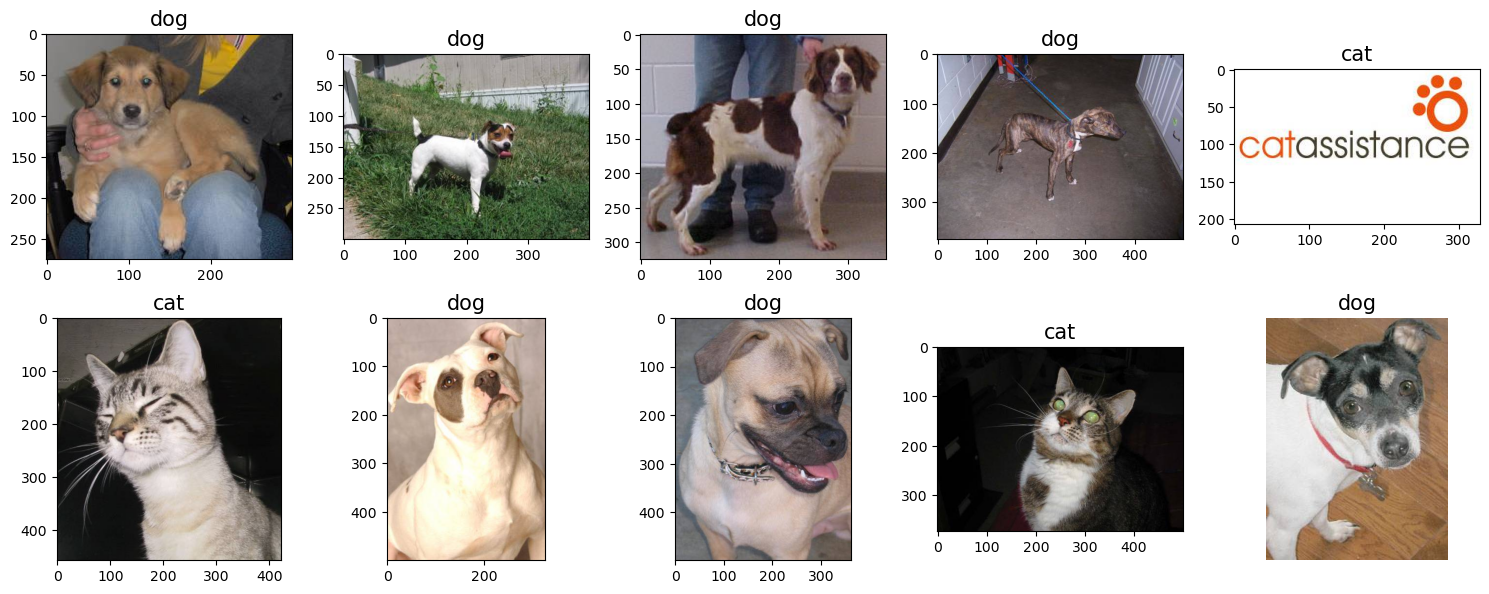

In [5]:
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure(figsize = (15,6))
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    img_path = train_list[idx]
    label = img_path.split('/')[-1].split('.')[0]
    plt.imshow(img)
    plt.title(label, size=15)
    i+=1
    
plt.tight_layout()
plt.axis('off')
plt.show()

### 2.3 Check the original sizes of the training images and channels <a class="anchor" id="23"></a>

In [6]:
h_list = []
w_list = []
band_set = set()
for train_img in train_list:
    img = Image.open(train_img)
    w, h = img.size
    h_list.append(h)
    w_list.append(w)
    band_set.add(img.getbands())
    
w_med, h_med = np.percentile(w_list, q = 80), np.percentile(h_list, q = 80)
print('80 percentile width of all the training images = ', w_med, 
      '\n80 percentile height of all the training images =', h_med)
print('channels of the training images:', band_set)

80 percentile width of all the training images =  500.0 
80 percentile height of all the training images = 456.0
channels of the training images: {('R', 'G', 'B')}


### 2.4 Image augmentation during data loading <a class="anchor" id="24"></a>

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(SEED)
if device =='cuda':
    torch.cuda.manual_seed_all(SEED)
print("device:", device)

device: cuda


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([512,512]),
        transforms.RandomHorizontalFlip(),
        transforms.Resize([256,256]),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor()
    ])
}

In [4]:
class dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img, label

In [10]:
trlist, valist = train_test_split(train_list, test_size=0.1)

tr_ds = dataset(trlist, transform=data_transforms['train'])
va_ds = dataset(valist, transform=data_transforms['test'])
te_ds = dataset(test_list, transform=data_transforms['test'])

# tr_ds = Subset(tr_ds, torch.arange(1000))
# va_ds = Subset(va_ds, torch.arange(100))

batch_size = 32
torch.manual_seed(SEED)
num_workers = multiprocessing.cpu_count()
tr_dl = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers = num_workers, pin_memory = True)
va_dl = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers = num_workers, pin_memory = True)

### 2.5 Check image augmentation <a class="anchor" id="25"></a>

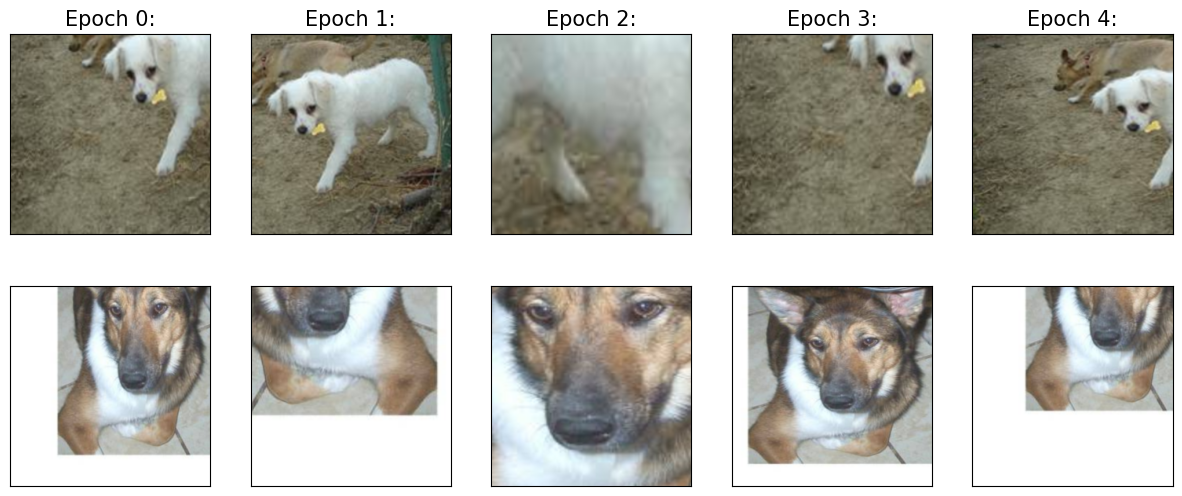

In [11]:
tmp_dl = DataLoader(tr_ds, batch_size=2)
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(tmp_dl))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
plt.show()

## 3. Build a CNN model <a class="anchor" id="3"></a>

### 3.1 Define model <a class="anchor" id="31"></a>

In [12]:
model = nn.Sequential()
kernel_size = 3
padding = (kernel_size - 1) // 2
model.add_module('conv1',
                nn.Conv2d(in_channels = 3,
                         out_channels = 32,
                         kernel_size = kernel_size,
                         padding = padding))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout1', nn.Dropout(p = 0.5))

model.add_module('conv2', nn.Conv2d(in_channels = 32, 
                                    out_channels = 64,
                                    kernel_size = kernel_size, 
                                    padding = padding
                                   )
                )
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout2', nn.Dropout(p = 0.5))

model.add_module('conv3', nn.Conv2d(in_channels = 64, 
                                    out_channels = 128,
                                    kernel_size = kernel_size, 
                                    padding = padding
                                   )
                )
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout3', nn.Dropout(p = 0.5))

model.add_module('conv4', nn.Conv2d(in_channels = 128, 
                                    out_channels = 256,
                                    kernel_size = kernel_size, 
                                    padding = padding
                                   )
                )
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size = 2))
model.add_module('dropout4', nn.Dropout(p = 0.5))

model.add_module('conv5', nn.Conv2d(in_channels = 256, 
                                    out_channels = 512,
                                    kernel_size = kernel_size, 
                                    padding = padding
                                   )
                )
model.add_module('relu5', nn.ReLU())
# global average pooling layer
model.add_module('pool5', nn.AvgPool2d(kernel_size = 16))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(512,1))
model.add_module('sigmoid', nn.Sigmoid())

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu

### 3.2 Show NN using Torchviz <a class="anchor" id="32"></a>

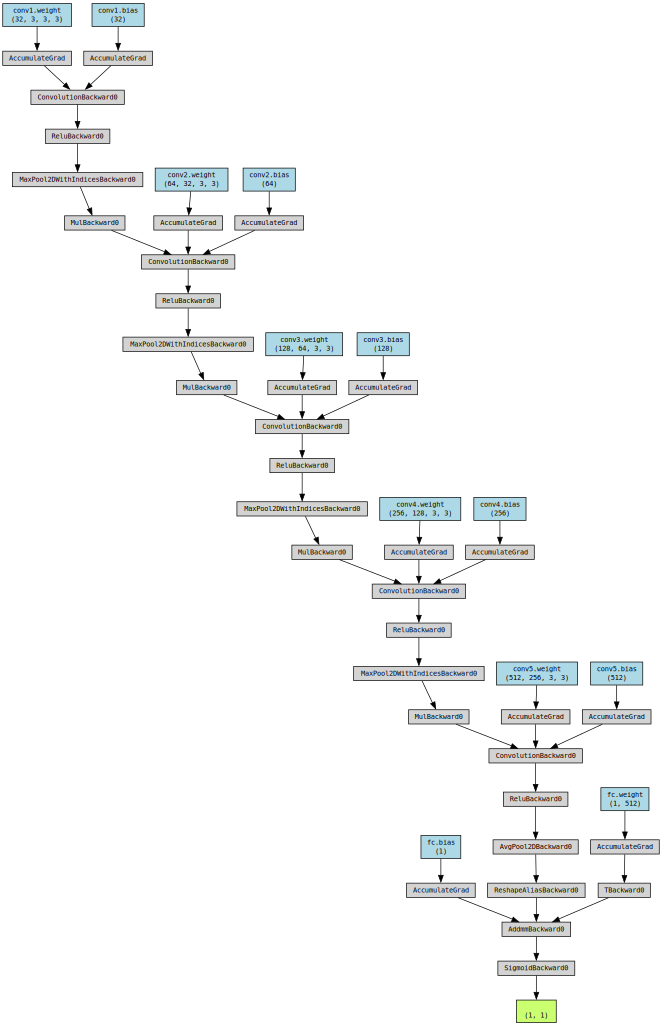

In [13]:
x = torch.ones([1, 3, 256, 256])
y = model(x)
make_dot(y, params=dict(list(model.named_parameters())))#.render("attached_model", format="png")

### 3.3 Choose loss function, optimizer <a class="anchor" id="33"></a>

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### 3.4 Train model <a class="anchor" id="34"></a>

In [15]:
def train(model, num_epochs, train_dl, valid_dl):
    model.to(device)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    start_time = time.time() 
    for epoch in range(num_epochs):
        
        model = model.train()
        for batch_idx, (x_batch, y_batch) in enumerate(train_dl):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
            
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dl), loss))
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model = model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [16]:
torch.manual_seed(SEED)
num_epochs = 60
history = train(model, num_epochs,
               tr_dl, va_dl)

Epoch: 001/060 | Batch 000/704 | Loss: 0.6896
Epoch: 001/060 | Batch 050/704 | Loss: 0.6923
Epoch: 001/060 | Batch 100/704 | Loss: 0.6936
Epoch: 001/060 | Batch 150/704 | Loss: 0.6951
Epoch: 001/060 | Batch 200/704 | Loss: 0.6907
Epoch: 001/060 | Batch 250/704 | Loss: 0.6968
Epoch: 001/060 | Batch 300/704 | Loss: 0.6939
Epoch: 001/060 | Batch 350/704 | Loss: 0.6982
Epoch: 001/060 | Batch 400/704 | Loss: 0.6932
Epoch: 001/060 | Batch 450/704 | Loss: 0.6936
Epoch: 001/060 | Batch 500/704 | Loss: 0.6931
Epoch: 001/060 | Batch 550/704 | Loss: 0.6924
Epoch: 001/060 | Batch 600/704 | Loss: 0.6929
Epoch: 001/060 | Batch 650/704 | Loss: 0.6937
Epoch: 001/060 | Batch 700/704 | Loss: 0.6935
Epoch 1 accuracy: 0.4990 val_accuracy: 0.5044
Time elapsed: 1.61 min
Epoch: 002/060 | Batch 000/704 | Loss: 0.6933
Epoch: 002/060 | Batch 050/704 | Loss: 0.6934
Epoch: 002/060 | Batch 100/704 | Loss: 0.6939
Epoch: 002/060 | Batch 150/704 | Loss: 0.6930
Epoch: 002/060 | Batch 200/704 | Loss: 0.6938
Epoch: 002/

### 3.4 Visualize the learning curve  <a class="anchor" id="34"></a>

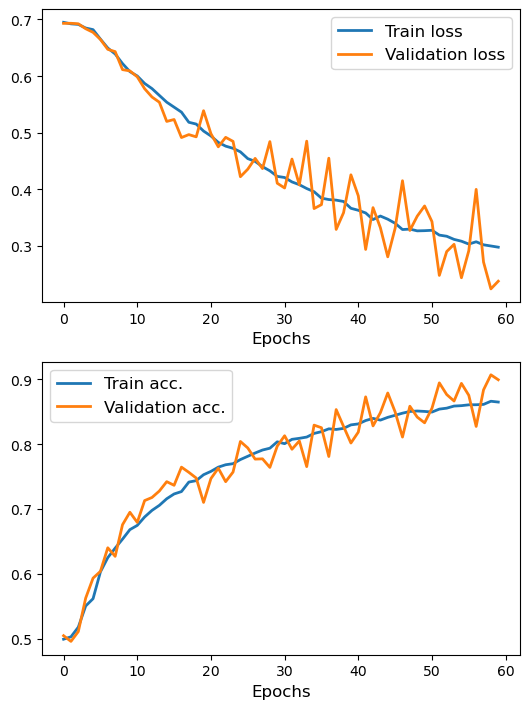

In [17]:
my_dpi = 100
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(540/my_dpi, 720/my_dpi), dpi=my_dpi)
ax[0].plot(history[0], lw=2)
ax[0].plot(history[1], lw=2)
ax[0].legend(['Train loss', 'Validation loss'], fontsize=12)
ax[0].set_xlabel('Epochs', size=12)
ax[1].plot([i.cpu() for i in history[2]], lw=2)
ax[1].plot([i.cpu() for i in history[3]], lw=2)
ax[1].legend(['Train acc.', 'Validation acc.'], fontsize=12)
ax[1].set_xlabel('Epochs', size=12);
plt.tight_layout()
plt.savefig(f'model_train_history.png', dpi = my_dpi);

## 4. Make predictions on test set  <a class="anchor" id="4"></a>

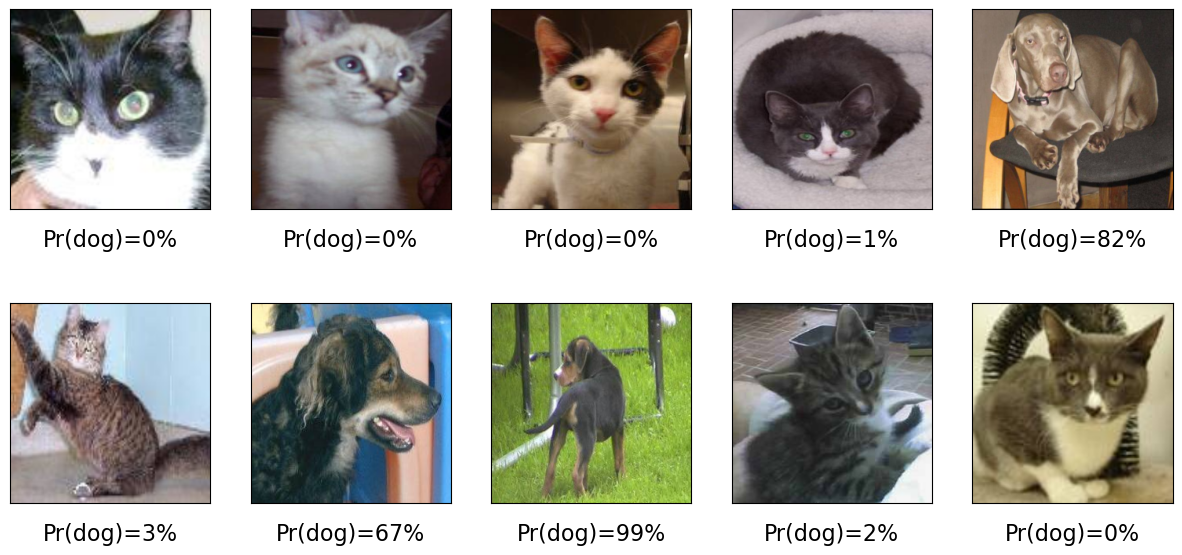

In [18]:
model.eval()
te_dl = DataLoader(te_ds, batch_size=batch_size, shuffle=True, num_workers = num_workers, pin_memory = True)

with torch.no_grad():
    for x_batch, y_batch in te_dl:
        break
        
x_batch = x_batch.to(device)
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))

    ax.text(
        0.5, -0.15,
        f'Pr(dog)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )
plt.show()

In [29]:
# Saving the model
torch.save(model, 'model.pth')

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu

In [5]:
# Loading the model
model = torch.load('model.pth')
model.eval()  # Set the model to inference mode

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu

In [6]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[[[ 6.4730e-02, -1.2664e-01,  1.8256e-02],
          [-1.9592e-02, -4.0922e-04, -1.8640e-02],
          [ 3.7258e-02,  5.8222e-02, -2.1229e-01]],

         [[ 4.7439e-02, -1.9249e-01, -1.7878e-01],
          [-3.6528e-02, -7.8806e-02,  8.7907e-02],
          [-1.4543e-01, -2.0754e-01,  9.9589e-02]],

         [[-5.7577e-02,  7.2919e-02,  3.0946e-02],
          [-1.6001e-01,  1.0751e-02,  2.4040e-02],
          [-1.5444e-01, -1.4359e-01,  1.0407e-02]]],


        [[[-5.3217e-02, -2.7169e-01, -2.6602e-01],
          [ 1.1177e-01, -2.5166e-01, -1.5421e-01],
          [ 7.5932e-02, -2.9169e-01, -3.9470e-01]],

         [[ 4.4465e-01,  1.7918e-01,  2.7129e-01],
          [ 3.1881e-01,  2.0768e-01,  2.3323e-01],
          [ 4.8517e-01,  3.4098e-02,  1.1487e-01]],

         [[ 9.5376e-02,  3.1045e-02,  3.1934e-02],
          [-1.9847e-01, -3.1650e-01, -3.0447e-01],
          [-1.5524e-02,  1.7442e-02, -3.3197e-01]]],


        [[[-6.9558e-02, -3.0759e-01, -3.9386

In [7]:
import os
rawdataPath = os.path.join(os.path.abspath(".."),"rawdata\\catdog")
rootPath = os.getcwd()
dataPath = os.path.join(rootPath,"data")
modelPath = os.path.join(rootPath,"model")
trainPath = os.path.join(rawdataPath,"train")
testPath = os.path.join(rawdataPath,"test")
test_path = glob.glob(os.path.join(testPath, '*.jpg'))

In [8]:
te_ds = dataset(test_path, transform=data_transforms['test'])

# tr_ds = Subset(tr_ds, torch.arange(1000))
# va_ds = Subset(va_ds, torch.arange(100))

# batch_size = 32
torch.manual_seed(42)
num_workers = multiprocessing.cpu_count()
sub_dl = DataLoader(te_ds, shuffle=False)

In [9]:
results = []
# sub_dl = DataLoader(te_ds, shuffle=False, num_workers = num_workers, pin_memory = True)  #, batch_size=len(te_ds),

In [12]:
for i, data in enumerate(sub_dl):
    print(i, data)
    break

0 [tensor([[[[0.1529, 0.1451, 0.1529,  ..., 0.3333, 0.2549, 0.1843],
          [0.1686, 0.1529, 0.1412,  ..., 0.3333, 0.2510, 0.1882],
          [0.1569, 0.1333, 0.1294,  ..., 0.3451, 0.2627, 0.1961],
          ...,
          [0.6627, 0.6980, 0.7176,  ..., 0.4588, 0.4510, 0.4510],
          [0.6431, 0.6784, 0.7137,  ..., 0.4510, 0.3765, 0.3804],
          [0.6667, 0.6706, 0.6980,  ..., 0.5843, 0.4588, 0.4275]],

         [[0.2588, 0.2471, 0.2549,  ..., 0.4706, 0.3961, 0.3294],
          [0.2745, 0.2549, 0.2431,  ..., 0.4627, 0.3882, 0.3255],
          [0.2627, 0.2353, 0.2314,  ..., 0.4549, 0.3804, 0.3216],
          ...,
          [0.6784, 0.7137, 0.7333,  ..., 0.4549, 0.4471, 0.4431],
          [0.6588, 0.6941, 0.7255,  ..., 0.4392, 0.3647, 0.3647],
          [0.6824, 0.6863, 0.7098,  ..., 0.5451, 0.4235, 0.3922]],

         [[0.3765, 0.3725, 0.3922,  ..., 0.8471, 0.7529, 0.6784],
          [0.3922, 0.3843, 0.3804,  ..., 0.8431, 0.7529, 0.6745],
          [0.3804, 0.3647, 0.3686,  ...

In [13]:
len(data)

2

In [52]:
@torch.no_grad()
def predict(x, model):
    model.eval()
    prediction = model(x)
    maxvalues, argmax = prediction.max(-1)
    prediction = argmax.cpu().detach().numpy()
    return 1 if prediction < 0.5 else 0

In [44]:
results = []
with torch.no_grad():
    for i, data in enumerate(sub_dl):
        input, filename = data
        input = input.to(device)
        output = predict(input, model)
        print(output)
        break
        # input = input.to(device)
        # output = predict(input, model)
        # results.append(output)
        # probabilities = 
    #     print(output)
    #     break 
    # # dog_probabilities = probabilities[:, 1]
    # # print(probabilities, dog_probabilities)
    # # bre                                                                     

[0]


In [46]:
predict(input,model)

array([0], dtype=int64)

In [47]:
model(input)

tensor([[0.8943]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [30]:
len(results)

12500

In [65]:
import torch
from PIL import Image
import torchvision.transforms as transforms
test_transform = transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor()
    ])
predictions = []
# Load the model
model = torch.load('model.pth')
model.to(device)
model.eval()  # Set the model to evaluation mode

# Define the transformation
prediction = []
# List of image paths
# Process and predict for each image
for image_path in test_path:
    # Load and transform the image
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)


    # Make a prediction
    with torch.no_grad():
        prediction = model(image)
        
        predictions.append(1 if float(prediction.cpu().detach().numpy()) < 0.5 else 0)
        

    # Process the prediction as needed
    # E.g., for classification tasks:
    # predicted_class = prediction.argmax(dim=1)
    # print("Predicted Class for image", image_path, ":", predicted_class.item())


C:\Users\guoyy\AppData\Local\Temp\ipykernel_28012\1185641577.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append(1 if float(prediction.cpu().detach().numpy()) < 0.5 else 0)


In [66]:
sub_df = pd.DataFrame({
    "id" : pd.Series(np.arange(1,12501)),
    "label" : predictions
})     

In [67]:
sub_df.to_csv("sub_cnn.csv", sep=",", index=False)